In [22]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [32]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(train_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='categorical')
val_data_gen = validation_image_generator.flow_from_directory(validation_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='categorical')
#test_data_gen = test_image_generator.flow_from_directory(test_dir, batch_size=total_test, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='categorical', shuffle=False)

test_image_filenames = sorted(os.listdir(test_dir))
test_image_paths = [os.path.join(test_dir, fname) for fname in test_image_filenames]

# Create a DataFrame with filenames (and dummy labels if required)
test_df = pd.DataFrame({
    'filename': test_image_filenames,
    # You can add dummy labels if class_mode != None
})

test_data_gen = test_image_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,                 # No labels since test data is unlabeled
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=total_test,
    class_mode=None,            # Important: no labels
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


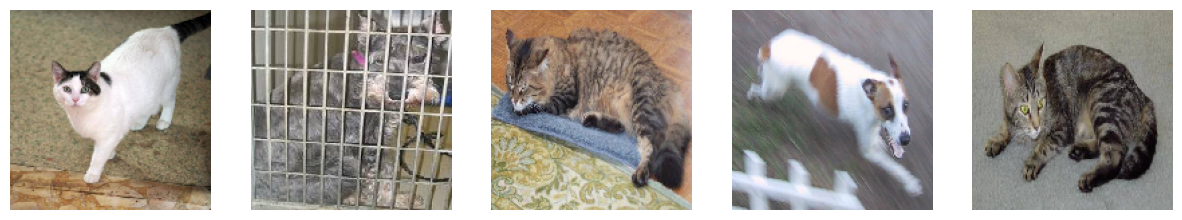

In [6]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(len(images_arr) * 3,5))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [7]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,             # rescale pixel values to [0,1]
    rotation_range=40,          # random rotation between 0-40 degrees
    width_shift_range=0.2,      # horizontal shift up to 20%
    height_shift_range=0.2,     # vertical shift up to 20%
    shear_range=0.2,            # shear transformation
    zoom_range=0.2,             # zoom in/out by 20%
    horizontal_flip=True,       # random horizontal flips
    fill_mode='nearest'         # fill mode for points outside boundaries
)


Found 2000 images belonging to 2 classes.


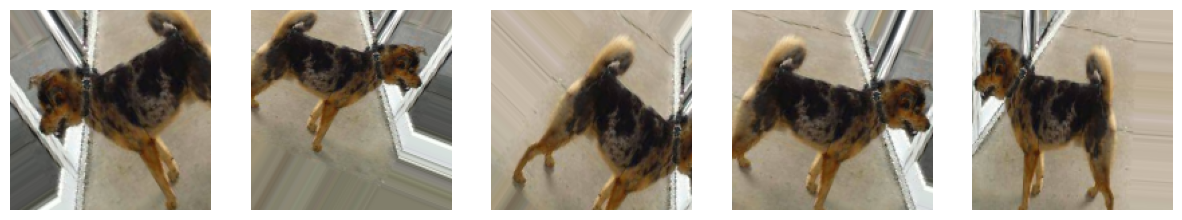

In [12]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [14]:
# 7
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),

    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,690 (72.61 MB)

 Trainable params: 19,034,690 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 8
history = history = model.fit(train_data_gen,
                              steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
                              epochs=epochs,
                              validation_data=val_data_gen,
                              validation_steps=val_data_gen.samples // val_data_gen.batch_size
                              )

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 123s 8s/step - accuracy: 0.5038 - loss: 1.1822 - val_accuracy: 0.5100 - val_loss: 0.6914
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:35 7s/step - accuracy: 0.5547 - loss: 0.6792

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5547 - loss: 0.6792 - val_accuracy: 0.5089 - val_loss: 0.6915
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 124s 8s/step - accuracy: 0.5396 - loss: 0.6894 - val_accuracy: 0.5837 - val_loss: 0.6812
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5312 - loss: 0.6927 - val_accuracy: 0.5737 - val_loss: 0.6814
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.5562 - loss: 0.6858 - val_accuracy: 0.5960 - val_loss: 0.6694
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6094 - loss: 0.6743 - val_accuracy: 0.5636 - val_loss: 0.6680
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - accuracy: 0.5791 - loss: 0.6734 - val_accuracy: 0.5658 - val_loss: 0.6798
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4453 - loss: 0.7184 - val_accuracy: 0.5792 - val_loss: 0.6730
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 130s 9s/step - accuracy: 0.5819 - loss: 0.6734 - val_accuracy: 0.6417 - val_loss: 0.633

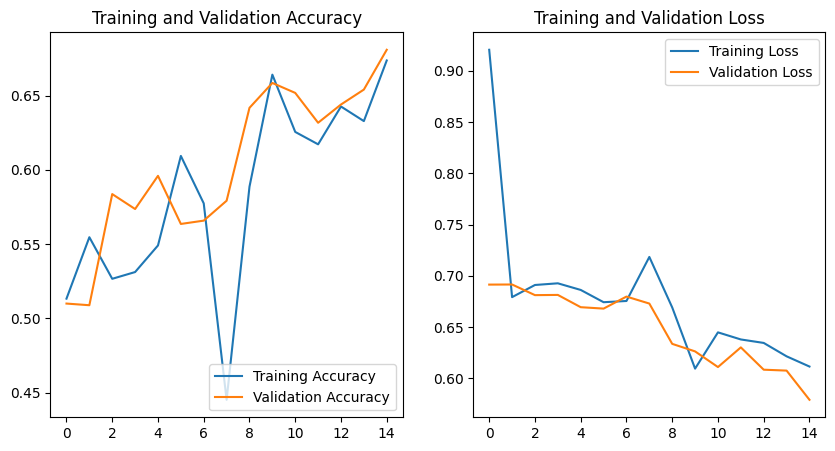

In [18]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
# 10
images = next(test_data_gen)
predictions = model.predict(images)
probabilities = (np.argmax(predictions, axis=1)).astype(int).tolist()
print(probabilities)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]


In [34]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!
